## 4 Running statmorph

Here we show an example statmorph run for one of the augmented galaxies. This is pretty straightforward!

We use `statmorph_lsst`, which includes some edits to the original code. All of the changes will be documented on the GitHub page. As of now, the major changes are:

* New `isophote_asymmtry` is introduced (optional, needs passing the `asymmetry_isophotes` argument)
* New `substructure` is intrpoduced
* Shape asymmetry, Gini, and MID segmaps are now generated on an image where enclosed masked pixels are interpolated over
    * This deals with the issue where long masked streaks (e.g., bad columns, satellites) break up the source segmap, causing the source to be deblended into two sources
 
#### Imports

In [63]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

import json
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from astropy.io import fits
from statmorph_lsst import statmorph
from statmorph_lsst.utils import rle_to_segmap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the image

Choose one galaxy to run statmorph for as an example

In [53]:
catalog = pd.read_csv('../data/catalogs/augments.csv')
row = catalog.sample(n=1, random_state=313).iloc[0]
row = catalog.sample(n=1, random_state=327).iloc[0]
row

galaxy            ngc1222
pxscale_pc        249.349
pxscale_arcsec      1.506
sblim               23.75
Name: 1857, dtype: object

Load in the data and the segmap

In [54]:
# Load the cutout fits file
file = fits.open(f'../data/augments/{row.galaxy}/px{int(row.pxscale_pc)}_sb{row.sblim:0.2f}.fits')

# Relevant arrays
img = file['SCI'].data
err = file['ERR'].data
mask = file['MASK'].data > 0
h = file['SCI'].header
psf = file['PSF'].data

# Segmap and foreground source mask
with open(f'../data/segmaps/{row.galaxy}/px{int(row.pxscale_pc)}_sb{row.sblim:0.2f}.json', 'r') as f:
    segmap_dict = json.load(f)
    segmap = rle_to_segmap(segmap_dict['segmap']) 
    segmask = rle_to_segmap(segmap_dict['segmask']) > 0

Plot the image and the segmap

/var/folders/_w/6csvq9qx0611l8s_lvbrrpyh0000gn/T/ipykernel_13949/2956007119.py:4: RuntimeWarning: invalid value encountered in divide
  axs[1].imshow(img/err, vmin=0, vmax=10, cmap='gray_r')


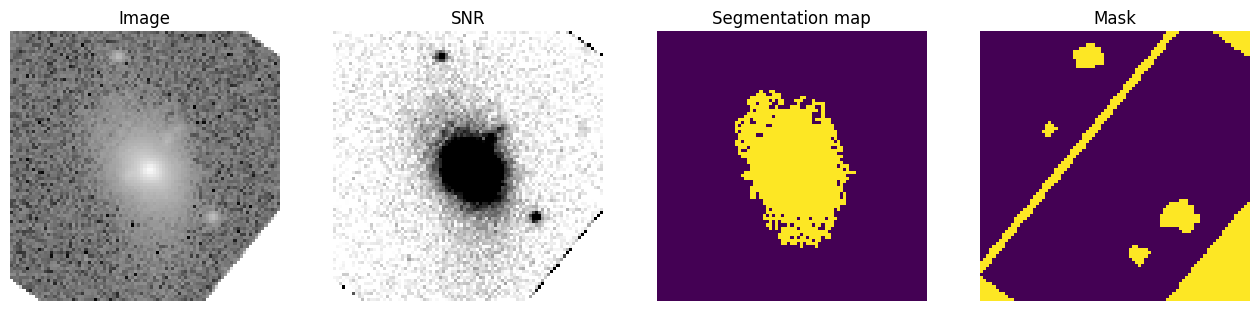

In [55]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].imshow(-2.5*np.log10(np.abs(img)/h['pxscale']**2)+h['zp'], vmin=17, vmax=30, cmap='gray_r')
axs[1].imshow(img/err, vmin=0, vmax=10, cmap='gray_r')
axs[2].imshow(segmap)
axs[3].imshow(segmask | mask)

labels = ['Image', 'SNR', 'Segmentation map', 'Mask']
for ax, l in zip(axs, labels):
    ax.set_title(l)
    ax.axis('off')

## Run statmorph

To calculate isophotal asymmetry we need to define the asymmetry isophotes. Let's define them as different surface brightness levels (which is what I'd recomment, since these map to $L_\odot/$pc$^2$).

In [56]:
sb_isophotes = np.arange(17, 25, 0.5)
img_isophotes = np.power(10, (h['zp']-sb_isophotes)/2.5) * h['pxscale']**2

Run statmorph:

In [75]:
morph = statmorph.source_morphology(img, segmap=segmap, mask=segmask|mask, weightmap=err, psf=psf, asymmetry_isophotes=img_isophotes)

/Users/liza/work/projects/statmorph-lsst/test_suite/nbs/../../statmorph_lsst/statmorph.py:753: RuntimeWarning: invalid value encountered in subtract
  local_std = np.sqrt(local_mean2 - local_mean**2)


Diagnostic plot:

In [86]:
from statmorph_lsst.utils import image_diagnostics

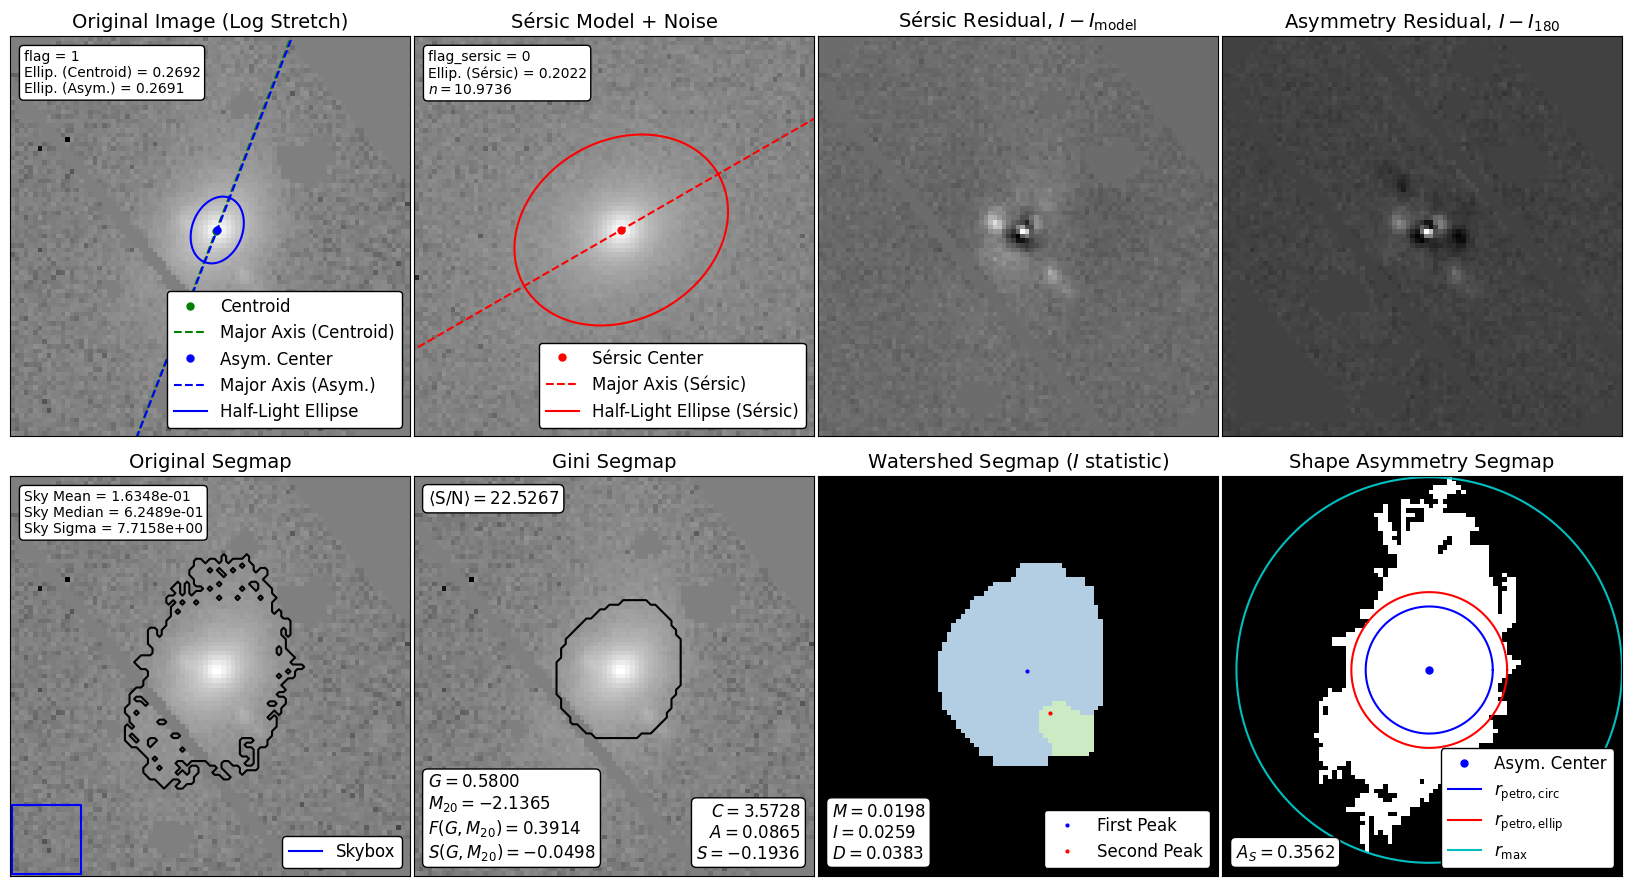

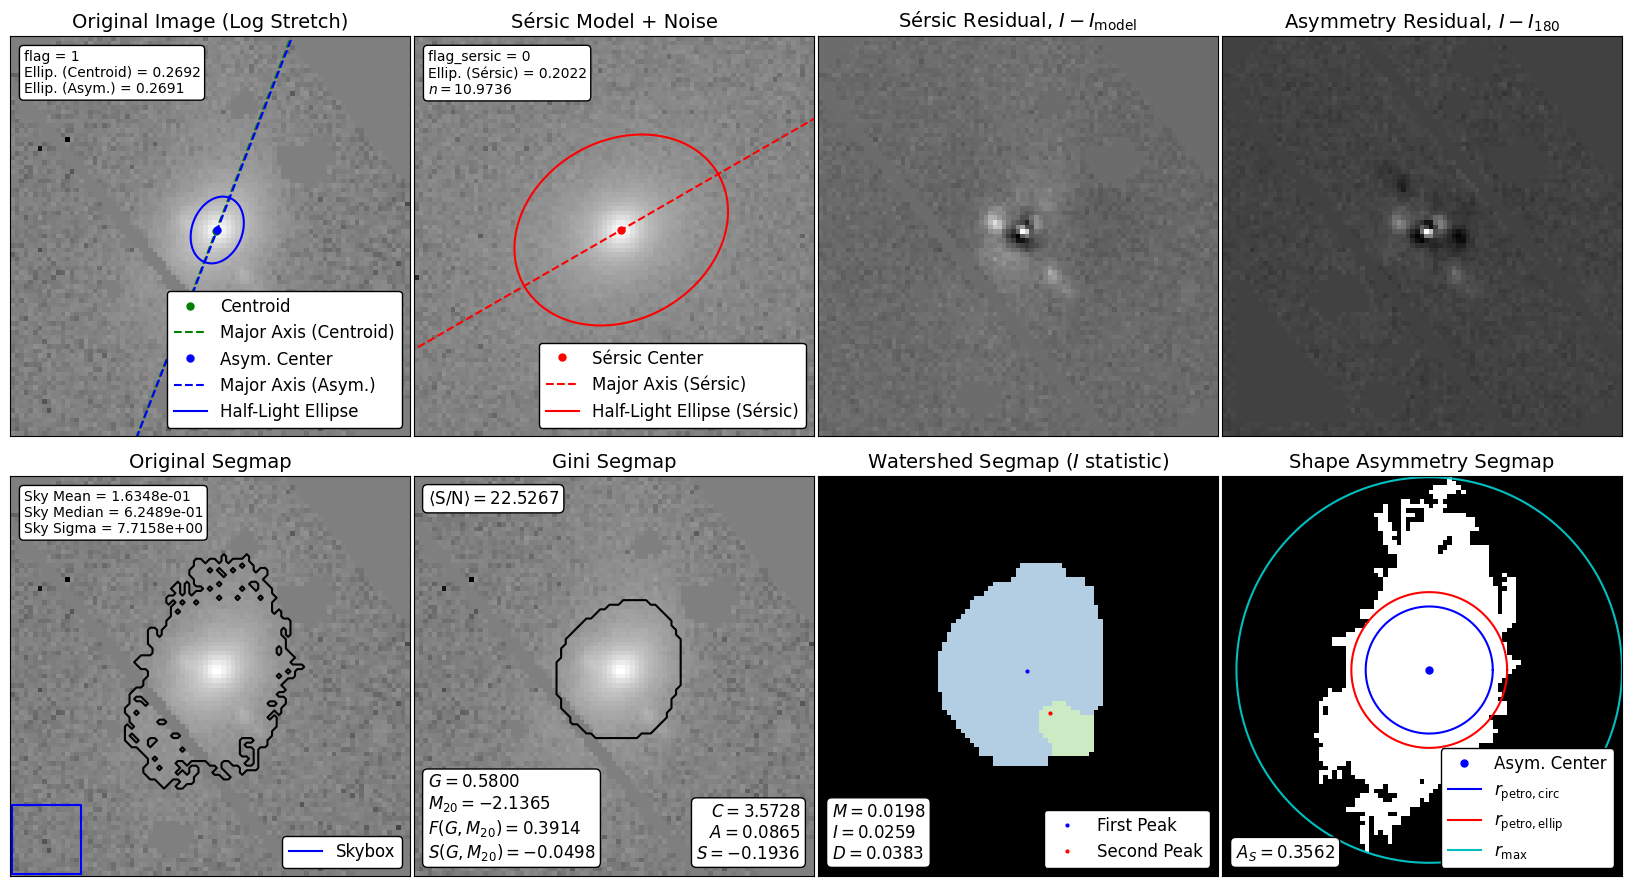

In [87]:
image_diagnostics.make_figure(morph[0])

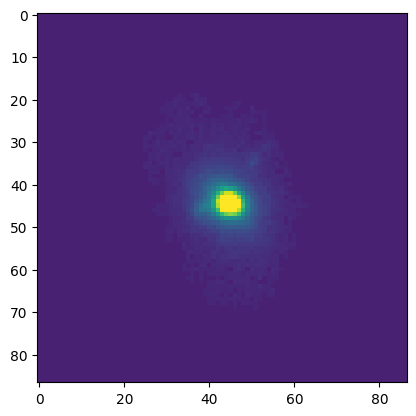

In [92]:
plt.imshow(morph[0]._cutout_stamp_interp, vmin=-100, vmax=1000)